In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Input, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os

from clearml import Task, Logger

2026-01-02 17:11:39.235425: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-02 17:11:39.280136: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-02 17:11:40.336859: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/home/id/sandbox/MAI/nn/venv/lib/python3.12/site-packages/keras/src/

### Посмотрим на размеры картинок в датасете. Видим, что они одинаковые, так что нам не придется их приводить к единому размеру

In [2]:
from PIL import Image

image = Image.open("data/lab1_2_6/4.Scenes_buildings_vs_forest/buildings/19915.jpg")
print(image.width, image.height)

150 150


### Настроим основные гиперпараметры

Обучение моделей буду дополнительно логировать в ClearML, чтобы дополнительно к лабам поиграться-поучиться/привыкнуть пользоваться им (нужно для работы)

In [3]:
# Инициализация задачи ClearML (замените 'my_project' и 'my_exp' на свои)
task = Task.init(project_name='here_we_go_again', task_name='CNN Binary Classifier - Buildings vs Forest')

# Гиперпараметры процесса обучения
EPOCHS = 10
BATCH_SIZE=120
 # Примерный размер, можно изменить
NUM_CLASSES = 2 # binary classification


ClearML Task: overwriting (reusing) task id=f900ee3b00394376a558804600c3231a
ClearML results page: http://10.31.10.2:8080/projects/238712d43c2843d2ab9525fa5f876cd8/experiments/f900ee3b00394376a558804600c3231a/output/log


ClearML results page: http://10.31.10.2:8080/projects/238712d43c2843d2ab9525fa5f876cd8/experiments/f900ee3b00394376a558804600c3231a/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


### Загрузим датасет и нормализуем значения пикселей

In [4]:
data_dir = "data/lab1_2_6/4.Scenes_buildings_vs_forest"

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2, # 20% данных для валидации
    subset="training",
    seed=123,
    image_size=(image.height, image.width),
    batch_size=BATCH_SIZE,
    label_mode='binary' # Для бинарной классификации
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(image.height, image.width),
    batch_size=BATCH_SIZE,
    label_mode='binary'
)

# Нормализуем значения пикселей к диапазону [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Found 4462 files belonging to 2 classes.
Using 3570 files for training.
CLEARML-SERVER new package available: UPGRADE to v2.3.0 is recommended!
Release Notes:
### New Features and Improvements

- New Project Workloads dashboard: View project resource utilization by resource, user, and subproject
- New Global Search advanced mode: Direct API filter specification for more specific queries
- Improve single-value scalar Compare view: Separate plot per variant when grouping by metric
- Enable customizing the default name format of cloned tasks 

### Bug Fixes

- Fix UI GCS credentials popup continues reappearing after broken upload #296
- Fix UI sometimes fails to load large task console logs #295
- Fix deleting parameter in UI task configuration causes other parameters to be duplicated or incorrectly modified 
- Fix deleting task in UI removes fileserver folders when "Remove all related artifacts" is not selected
- Fix UI pipeline runs sometimes do not resolve step parameters which are the

2026-01-02 17:11:44.497425: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


### Создадим простенькую модель-классификатор

In [5]:
model = Sequential([
           Input(shape=(image.height, image.width, 3)), # 3 канала для RGB
           Conv2D(32, (3, 3), activation='relu'),
           MaxPooling2D((2, 2)),
           Conv2D(64, (3, 3), activation='relu'),
           MaxPooling2D((2, 2)),
           Conv2D(256, (3, 3), activation='relu'),
           Flatten(),
           Dense(40, activation='relu'),
           # Изменяем последний слой на 1 нейрон с сигмоидой для бинарной классификации
           Dense(1, activation='sigmoid'), 
        ]
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 295936)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │    11,837,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,004,625 (45.79 MB)

 Trainable params: 12,004,625 (45.79 MB)

 Non-trainable params: 0 (0.00 B)

### Настроим модель для обучения, дополнительно добавив механизм ранней остановки для предотввращения переобучения

In [6]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(loss='binary_crossentropy', # Меняем функцию потерь именно для бинарной классификации
              optimizer=Adam(learning_rate=3e-4),
              metrics=['accuracy'])


# Создание колбэка
early_stopping_callback = EarlyStopping(
    monitor='val_loss', # Метрика, за которой следим
    patience=2,
    min_delta=0.001 ,
    restore_best_weights=True # Восстановить веса модели с наилучшей метрикой
)

### Обучим модель

In [7]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[early_stopping_callback]
                    )

Epoch 1/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 447ms/step - accuracy: 0.7406 - loss: 0.4940 - val_accuracy: 0.9047 - val_loss: 0.2423
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 13s 446ms/step - accuracy: 0.9216 - loss: 0.2126 - val_accuracy: 0.9047 - val_loss: 0.2442
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 450ms/step - accuracy: 0.9476 - loss: 0.1516 - val_accuracy: 0.9417 - val_loss: 0.1542
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 448ms/step - accuracy: 0.9594 - loss: 0.1161 - val_accuracy: 0.9439 - val_loss: 0.1602
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 451ms/step - accuracy: 0.9622 - loss: 0.1040 - val_accuracy: 0.9395 - val_loss: 0.1528
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 450ms/step - accuracy: 0.9731 - loss: 0.0844 - val_accuracy: 0.9585 - val_loss: 0.1202
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 449ms/step - accuracy: 0.9815 - loss: 0.0627 - val_accuracy: 0.9518 - val_loss: 0.1249
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 451ms/step - accuracy: 0.9815 - loss: 0.0568 - val_accu

In [15]:
history.history['loss']

[0.4939732253551483,
 0.21255072951316833,
 0.15161991119384766,
 0.11613944172859192,
 0.10398700088262558,
 0.08442002534866333,
 0.06266921758651733,
 0.056791387498378754]

### Посмотрим что там по графикам обучения

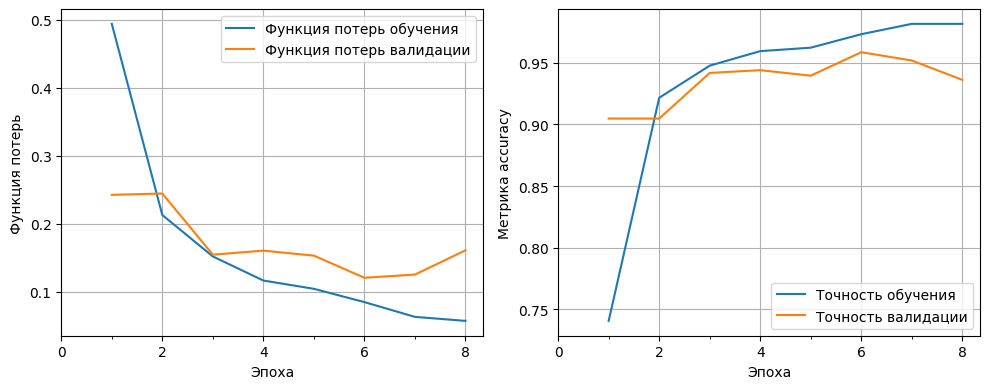

### TASK STOPPED - USER ABORTED - STATUS CHANGED ###


: 

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
# Обновляем названия метрик для бинарной классификации
axs[0].plot(np.arange(1, len(history.history["loss"]) + 1), history.history['loss'][:], label='Функция потерь обучения')
axs[0].plot(np.arange(1, len(history.history["loss"]) + 1), history.history['val_loss'][:], label='Функция потерь валидации')
axs[0].grid()
axs[0].set_xticks(np.arange(0, len(history.history["loss"]) + 1, 2))
axs[0].set_xticks(np.arange(0, len(history.history["loss"]) + 1, 1), minor=True)
axs[0].legend(prop={'size': 10})
axs[0].set_xlabel('Эпоха')
axs[0].set_ylabel('Функция потерь')

axs[1].plot(np.arange(1, len(history.history["loss"]) + 1), history.history['accuracy'][:], label='Точность обучения')
axs[1].plot(np.arange(1, len(history.history["loss"]) + 1), history.history['val_accuracy'][:], label='Точность валидации')
axs[1].grid()
axs[1].set_xticks(np.arange(0, len(history.history["loss"]) + 1, 2))
axs[1].set_xticks(np.arange(0, len(history.history["loss"]) + 1, 1), minor=True)
axs[1].legend(prop={'size': 10})
axs[1].set_xlabel('Эпоха')
axs[1].set_ylabel('Метрика accuracy')
plt.tight_layout()
plt.show()

### Потестируем модель

8/8 - 2s - 188ms/step - accuracy: 0.9585 - loss: 0.1202

Точность на валидационном наборе: 95.85%
Функция потерь на валидационном наборе: 0.1202
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


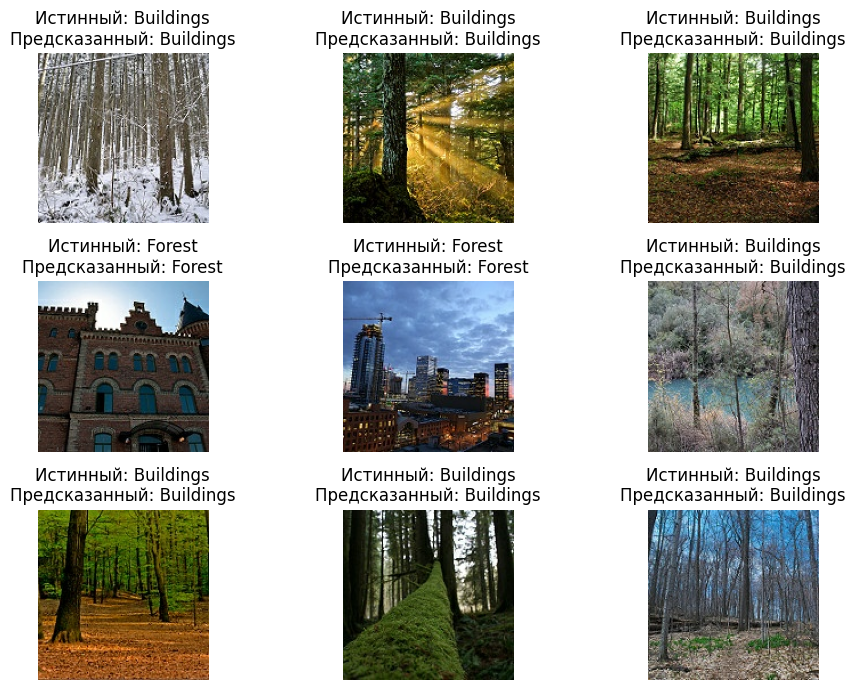

2026-01-02 17:21:01.967439: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
test_loss, test_accuracy = model.evaluate(val_ds, verbose=2)
print(f"\nТочность на валидационном наборе: {test_accuracy*100:.2f}%")
print(f"Функция потерь на валидационном наборе: {test_loss:.4f}")


labels_str = ["Forest", 'Buildings']
for images, labels in val_ds.take(1):
    predictions = model.predict(images)
    predicted_classes = (predictions > 0.5).astype(int).flatten()
    labels = labels.numpy().astype(int)

    plt.figure(figsize=(10, 7))
    for i in range(min(9, len(images))):  # Не превышать размер батча
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Истинный: {labels_str[labels[i][0]]}\nПредсказанный: {labels_str[int(predicted_classes[i])]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
